In [1]:
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time


In [2]:
# Define Chrome options
chrome_options = Options()
# chrome_options.add_argument("--headless")
# chrome_options.add_argument("--no-sandbox")
# Add more options here if needed

# Define paths
user_home_dir = os.path.expanduser("~")
chrome_binary_path = os.path.join(user_home_dir, "chrome-linux64", "chrome")
chromedriver_path = os.path.join(user_home_dir, "chromedriver-linux64", "chromedriver")

# Set binary location and service
chrome_options.binary_location = chrome_binary_path
webdriver_service = Service(chromedriver_path)

driver = webdriver.Chrome(service=webdriver_service, options=chrome_options)

<html lang="id" translate="no" data-rh="lang,translate"><head>
    <title>Situs Jual Beli Online Terlengkap, Mudah &amp; Aman | Tokopedia</title>
    <meta charset="UTF-8">
    <meta name="viewport" content="initial-scale=1, minimum-scale=1, maximum-scale=5, user-scalable=yes, width=device-width">
    <link rel="preconnect" href="https://assets.tokopedia.net" crossorigin=""><link rel="dns-prefetch" href="https://assets.tokopedia.net" nonce="">
<link rel="preconnect" href="https://gql.tokopedia.com" crossorigin=""><link rel="dns-prefetch" href="https://gql.tokopedia.com" nonce="">
<link rel="preconnect" href="https://googleads.g.doubleclick.net" crossorigin=""><link rel="dns-prefetch" href="https://googleads.g.doubleclick.net" nonce="">
<link rel="preconnect" href="https://www.google-analytics.com" crossorigin=""><link rel="dns-prefetch" href="https://www.google-analytics.com" nonce="">
<link rel="preconnect" href="https://images.tokopedia.net" crossorigin=""><link rel="dns-prefetch" hr
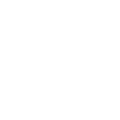
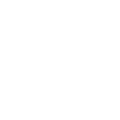
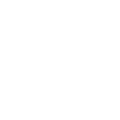

In [3]:
# Example of fetching a URL
driver.get("https://www.tokopedia.com/")
print(driver.page_source)  # Example of printing the page source

In [4]:
page_text = driver.find_element(By.TAG_NAME, "body").text
print(f"Full page text: {page_text}")  # Print the first 500 characters of the page text


Full page text: Download Tokopedia App
Tentang Tokopedia
Mitra Tokopedia
Mulai Berjualan
Promo
Tokopedia Care
Kategori
Masuk
Daftar
Meja Kantor
Regulator Gas
Sleeping Bag
Sepatu Running
Jas Hujan
Ac 1 Pk
Ke slide 1
Ke slide 2
Ke slide 3
Lihat Promo Lainnya
Kategori Pilihan
Top Up & Tagihan
Lihat Semua
Pulsa
Paket Data
Flight
Listrik PLN
Kategori
Handphone & Tablet
Top-Up & Tagihan
Elektronik
Perawatan Hewan
Travel & Entertainment
Keuangan
Komputer & Laptop


In [5]:
html_content = driver.page_source
print(f"HTML content: {html_content[:500]}")  # Print first 500 characters of HTML


HTML content: <html lang="id" translate="no" data-rh="lang,translate"><head>
    <title>Situs Jual Beli Online Terlengkap, Mudah &amp; Aman | Tokopedia</title>
    <meta charset="UTF-8">
    <meta name="viewport" content="initial-scale=1, minimum-scale=1, maximum-scale=5, user-scalable=yes, width=device-width">
    <link rel="preconnect" href="https://assets.tokopedia.net" crossorigin=""><link rel="dns-prefetch" href="https://assets.tokopedia.net" nonce="">
<link rel="preconnect" href="https://gql.tokopedia.c


In [6]:

import requests

api_key = "3mM44UdC76NLG7_BRVpu5duXpY6Quz3NcKy71"
secret_key = "LvZyPvCGiboWySpNrHmD1z"

headers = {
    "Authorization": f"sso-key {api_key}:{secret_key}",
    "Content-Type": "application/json"
}

def check_domain_availability(domain_name):
    url = f"https://api.ote-godaddy.com/v1/domains/available?domain={domain_name}"
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an error for bad responses
        
        data = response.json()
        if data.get('available'):
            print(f"{domain_name} is available!")
        else:
            print(f"{domain_name} is not available.")
    
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

# Example usage
check_domain_availability("xnxx.com")
check_domain_availability("pornhub.com")
check_domain_availability("aseanenery.com")
check_domain_availability("aseanenergy.org")

xnxx.com is not available.
pornhub.com is not available.
aseanenery.com is available!
aseanenergy.org is not available.


In [1]:
import pandas as pd

# File path for the CSV file
csv_file = '/home/jordinia/Projects/ML-Malicious-Web-Scraper/domains_and_content.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)




In [2]:
# Print the first few rows of the DataFrame (head)
print(df.head())

# Optional: Convert to numpy array if needed
numpy_data = df.to_numpy()

# Print the shape of the numpy array (for confirmation)
print(numpy_data.shape)

                   Domain                                            Content
0    http://000studio.com                                                  ﻿
1  http://021kongyaji.com  经典好看的电影作品大全_优质高清电影推荐排行榜_第1页_三年片在线观看大全有哪些\n首页\n...
2    http://0357yanke.com  仿盛大传奇1.76手机版.1.76版仿盛大热血传奇服务端-新开传奇SF--1.76传奇私服发...
3        http://0724e.com  开云·kaiyun(中国)体育官方网站-登录入口-2017好莱坞大师行，东方好莱坞影视文化基...
4   http://0735lawyer.com  《郴州市律师协会律师微博等自媒体平台使用准则》-行业规范-郴州市律师协会官方网\n加入收藏\...
(25550, 2)


In [4]:
print(df.iloc[16161])

Domain                                   https://vlex.com.br
Content    elementos essenciais da relação jurídica - pág...
Name: 16161, dtype: object
